In [26]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

from pylab import rcParams
# from plotly import tools
# import plotly.plotly as py
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.figure_factory as ff

import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# 1.load data

In [27]:
all_df = pd.read_csv("data/owid-covid-data.csv",  keep_default_na=False)
population_ = pd.read_csv('data/population_by_country_2020.csv')

In [28]:
population_.loc[population_['Country (or dependency)'] == 'United States', 'Country (or dependency)'] = "US"
population_.loc[population_['Country (or dependency)'] == 'South Korea', 'Country (or dependency)'] = "Korea, South"
population_.loc[population_['Country (or dependency)'] == 'Sao Tome & Principe', 'Country (or dependency)'] = "Sao Tome and Principe"
population_.loc[population_['Country (or dependency)'] == 'Taiwan', 'Country (or dependency)'] = "Taiwan*"

population_.loc[population_['Country (or dependency)'] == 'Myanmar', 'Country (or dependency)'] = "Burma"
population_.loc[population_['Country (or dependency)'] == 'Congo', 'Country (or dependency)'] = "Congo (Brazzaville)"
population_.loc[population_['Country (or dependency)'] == 'DR Congo', 'Country (or dependency)'] = "Congo (Kinshasa)"
population_.loc[population_['Country (or dependency)'] == "Côte d'Ivoire", 'Country (or dependency)'] = "Cote d'Ivoire"

population_.loc[population_['Country (or dependency)'] == 'Czech Republic (Czechia)', 'Country (or dependency)'] = "Czechia"
population_.loc[population_['Country (or dependency)'] == 'Saint Kitts & Nevis', 'Country (or dependency)'] = "Saint Kitts and Nevis"
population_.loc[population_['Country (or dependency)'] == 'St. Vincent & Grenadines', 'Country (or dependency)'] = "Saint Vincent and the Grenadines"


population_.rename({'Population (2020)': 'population', 'Country (or dependency)': 'country', 'Yearly Change': 'yearly_change', 
                 'Net Change': 'net_change', 'Density (P/Km²)': 'density', 'Land Area (Km²)': 'land_area', 
                 'Migrants (net)': 'migrants', 'Fert. Rate': 'rert_rate', 'Med. Age': 'med_age', 
                 'Urban Pop %': 'urban_pop', 'World Share': 'world_share'}, axis=1, inplace=True)
population_["yearly_change"] = population_["yearly_change"].apply(lambda x: x.replace(" ", "").replace("%","")).astype("float")
population_["urban_pop"] = population_["urban_pop"].apply(lambda x: x.replace(" ", "").replace("N.A.","0").replace("%","")).astype("float")
population_["world_share"] = population_["world_share"].apply(lambda x: x.replace(" ", "").replace("%","")).astype("float")

population_["rert_rate"] = population_["rert_rate"].apply(lambda x: x.replace("N.A.", "0.0")).astype("float")
population_["med_age"] = population_["med_age"].apply(lambda x: x.replace("N.A.", "0.0")).astype("float")

population_.rert_rate.fillna(0, inplace=True)
population_.migrants.fillna(0, inplace=True)

population_["net_change"] = population_["net_change"].astype("float")
population_["density"] = population_["density"].astype("float")
population_["land_area"] = population_["land_area"].astype("float")
population_["population"] = population_["population"].astype("float")

population_["r_population"] = population_["population"]

population_["population"] = population_["population"] / max(population_["population"])
population_["yearly_change"] = population_["yearly_change"] / max(population_["yearly_change"])
population_["urban_pop"] = population_["urban_pop"] / max(population_["urban_pop"])
population_["world_share"] = population_["world_share"] / max(population_["world_share"])
population_["net_change"] = population_["net_change"] / max(population_["net_change"])
population_["density"] = population_["density"] / max(population_["density"])
population_["land_area"] = population_["land_area"] / max(population_["land_area"])
population_["rert_rate"] = population_["rert_rate"] / max(population_["rert_rate"])
population_["med_age"] = population_["med_age"] / max(population_["med_age"])
population_["migrants"] = population_["migrants"] / max(population_["migrants"])

In [29]:
def deal_country_data(population_, train_df, oname, nname):
    data_df = train_df[train_df["location"] == oname]
    data_df["location"] = nname
    
    df = pd.DataFrame()
    df["country"] = data_df["location"]
    df["date"] = data_df["date"]
    df["confirmed"] = data_df["new_cases"]
    df["fatalities"] = data_df["new_deaths"]
    # df["population"] = train_df["population"]
    df["population_density"] = data_df["population_density"]
    df["median_age"] = data_df["median_age"]
    df["aged_65_older"] = data_df["aged_65_older"]
    df["aged_70_older"] = data_df["aged_70_older"]
     
    country_df = df.merge(population_, how="left", on=['country']).drop_duplicates()
    
    country_df.confirmed.fillna(0, inplace=True)
    country_df.fatalities.fillna(0, inplace=True)
    country_df["confirmed"] = pd.to_numeric(country_df["confirmed"])
    country_df["fatalities"] = pd.to_numeric(country_df["fatalities"])
    country_df["population_density"] = pd.to_numeric(country_df["population_density"])
    country_df["median_age"] = pd.to_numeric(country_df["median_age"])
    country_df["aged_65_older"] = pd.to_numeric(country_df["aged_65_older"])
    country_df["aged_70_older"] = pd.to_numeric(country_df["aged_70_older"])
    
    country_df["confirmed"] = np.abs(country_df["confirmed"])
    country_df["fatalities"] = np.abs(country_df["fatalities"])
    
    return  country_df

def deal_global_df(population_, train_df, oname, nname):
    data_df = train_df[train_df["location"] == oname]
    data_df["location"] = nname
    
    country_df = pd.DataFrame()
    country_df["country"] = data_df["location"]
    country_df["date"] = data_df["date"]
    country_df["confirmed"] = data_df["new_cases"]
    country_df["fatalities"] = data_df["new_deaths"]
    
    country_df.confirmed.fillna(0, inplace=True)
    country_df.fatalities.fillna(0, inplace=True)
    country_df["confirmed"] = pd.to_numeric(country_df["confirmed"])
    country_df["fatalities"] = pd.to_numeric(country_df["fatalities"])
    
    country_df["confirmed"] = np.abs(country_df["confirmed"])
    country_df["fatalities"] = np.abs(country_df["fatalities"])
    
    list_cur = []
    list_cur.append({"country":nname,
                "population":population_["population"].mean(),
                "yearly_change":population_["yearly_change"].mean(),
                "net_change":population_["net_change"].mean(),
                "density":population_["density"].mean(),
                "land_area":population_["land_area"].mean(),
                "migrants":population_["migrants"].mean(),
                "rert_rate":population_["rert_rate"].mean(),
                "med_age":population_["med_age"].mean(),
                "urban_pop":population_["urban_pop"].mean(),
                "world_share":population_["world_share"].mean()})
    df = pd.DataFrame(list_cur)
    
    data_df = country_df.merge(df, how="left", on=['country']).drop_duplicates()
    
    
    return data_df

def log2_(df):
    df = df[df["confirmed"] >= 3]
    df = df[df["fatalities"] >= 3]
    df["confirmed"] = np.log(np.log(df["confirmed"]))
    df["fatalities"] = np.log(np.log(df["fatalities"]))
    idex = list(range(0, df.shape[0]))
    df["day"] = idex
    return df

def plot_data(t):

    plt.plot(range(0, t.shape[0]), t["confirmed"])
    plt.plot(range(0, t.shape[0]), t["fatalities"])
    plt.title('Confirmed & Fatalities Data')
    plt.ylabel('confirmed & Fatalities')
    plt.xlabel('Epoch')
    plt.show()

def saveCsv(df, name):
    df = df.fillna(0)
    df.to_csv("/home/soul/NewWorkSpace/Informer2020CP/data/ETT/" + name + ".csv")
    
def addCsv(df): #累加
    temp_df = df
    confirmed_ = temp_df.confirmed.fillna(0).astype(np.float32)
    fatalities_ = temp_df.fatalities.fillna(0).astype(np.float32)
    confirmed_ = np.array(confirmed_).reshape(-1, 1)
    fatalities_ = np.array(fatalities_).reshape(-1, 1)
    for i in range(confirmed_.shape[0] - 1):
        confirmed_[i+1] += confirmed_[i]
    for i in range(fatalities_.shape[0] - 1):
        fatalities_[i+1] += fatalities_[i]    
    temp_df['confirmed'] = confirmed_
    temp_df['fatalities'] = fatalities_
    return temp_df

def plot_data(t):
    plt.plot(range(0, t.shape[0]), t["confirmed"])
    plt.plot(range(0, t.shape[0]), t["fatalities"])
    plt.title('Confirmed & Fatalities Data')
    plt.ylabel('confirmed & Fatalities')
    plt.xlabel('Epoch')
    plt.show()

from sklearn.preprocessing import StandardScaler
class StandData:
    def __init__(self):
        self.scaler1 = StandardScaler()
        self.scaler2 = StandardScaler()
    
    def standData_(self, df):

        confirmed_  = df.confirmed.fillna(0)
        fatalities_ = df.fatalities.fillna(0)

        confirmed_ = np.array(confirmed_)
        fatalities_ = np.array(fatalities_)

        self.scaler1.fit(confirmed_.reshape(-1, 1))
        confirmed_ = self.scaler1.transform(confirmed_.reshape(-1, 1)).reshape(-1)

        self.scaler2.fit(fatalities_.reshape(-1, 1))
        fatalities_ = self.scaler2.transform(fatalities_.reshape(-1, 1)).reshape(-1)
        
        temp_df = pd.DataFrame()
        temp_df["confirmed"] = confirmed_
        temp_df["fatalities"] = fatalities_
        idex = list(range(0, df.shape[0]))
        temp_df["day"] = idex
        return temp_df
    
    def transformDataConfirmed_(self, df):
        return self.scaler1.inverse_transform(df)
    
    def transformDataFatalities_(self, df):
        return self.scaler2.inverse_transform(df)
    
def error_mse(ty, py):
    mse = mean_squared_error(ty, py)
    return mse

def error_rmsle(ty, py):
    rmsle = np.sqrt(mean_squared_log_error(ty, py))
    return rmsle

def error_mae(ty, py):
    mae = mean_absolute_error(ty, py)
    return mae

def error_mape(ty, py):
    mape = np.mean(np.abs((py - ty) / ty)) 
    return mape

def error_rmse(ty, py):
    mse = mean_squared_error(ty, py)    
    rmse = np.sqrt(mse)
    return rmse

In [30]:
global_df = deal_global_df(population_, all_df, "World", "global")
us_df = deal_country_data(population_, all_df, "United States", "US")
italy_df  = deal_country_data(population_, all_df, "Italy", "Italy")    ####
france_df = deal_country_data(population_, all_df, "France", "France")  ####
japan_df  = deal_country_data(population_, all_df, "Japan", "Japan")    ####


china_df = deal_country_data(population_, all_df, "China", "China")
spain_df = deal_country_data(population_, all_df, "Spain", "Spain")
france_df = deal_country_data(population_, all_df, "France", "France")
uk_df = deal_country_data(population_, all_df, "United Kingdom", "United Kingdom")
germany_df = deal_country_data(population_, all_df, "Germany", "Germany")
india_df = deal_country_data(population_, all_df, "India", "India")

In [31]:

global_df = addCsv(global_df)
us_df     = addCsv(us_df)
italy_df  = addCsv(italy_df)
france_df = addCsv(france_df)
japan_df  = addCsv(japan_df)

china_df   = addCsv(china_df)
spain_df   = addCsv(spain_df)
uk_df      = addCsv(uk_df)
germany_df = addCsv(germany_df)
india_df = addCsv(india_df)

In [32]:
india_df

,country,date,confirmed,fatalities,population_density,median_age,aged_65_older,aged_70_older,population,yearly_change,net_change,density,land_area,migrants,rert_rate,med_age,urban_pop,world_share,r_population
0,India,2020-01-30,1.0,0.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
1,India,2020-01-31,1.0,0.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
2,India,2020-02-01,1.0,0.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
3,India,2020-02-02,2.0,0.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
4,India,2020-02-03,3.0,0.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,India,2021-04-21,15930774.0,184659.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
448,India,2021-04-22,16263695.0,186922.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
449,India,2021-04-23,16610481.0,189546.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
450,India,2021-04-24,16960172.0,192313.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09


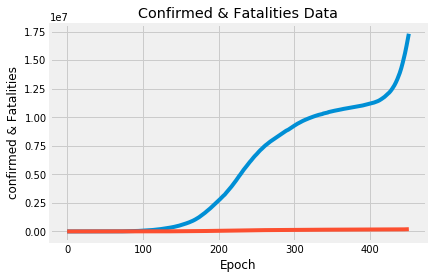

In [33]:
plot_data(india_df)

In [34]:
def baseling_ARMA(df, feature = "confirmed"):
    df = df.copy()
    standData = StandData()
    df = standData.standData_(df)
    model = ARMA(df['confirmed'].iloc[:-30], order=(1, 0)) #(1, 0)  (0, 1)  (0, 2) (0, 3) (3, 3)
    result = model.fit()
#     print(result.summary())
#     print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))
    rcParams['figure.figsize'] = 10, 8
    
    startLen = len(df) - 30
    endLen = len(df) - 1
    
    plt.plot(standData.transformDataConfirmed_(df['confirmed'].iloc[:]),color="red")       
    plt.plot(standData.transformDataConfirmed_(result.predict(start=startLen,end=endLen)),color="blue")    
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.show()
    plt.close()
    

    
    mse   = error_mse(df['confirmed'].iloc[-30:], result.predict(start=startLen,end=endLen))
    rmsle = error_rmsle(df['confirmed'].iloc[-30:], result.predict(start=startLen,end=endLen))
    mae   = error_mae(df['confirmed'].iloc[-30:], result.predict(start=startLen,end=endLen))
    mape  = error_mape(df['confirmed'].iloc[-30:], result.predict(start=startLen,end=endLen))
    rmse  = error_rmse(df['confirmed'].iloc[-30:], result.predict(start=startLen,end=endLen))
    print("mse: ", mse)
    print("rmsle: ", rmsle)
    print("mae: ", mae)
    print("mape: ", mape)
    print("rmse: ", rmse)

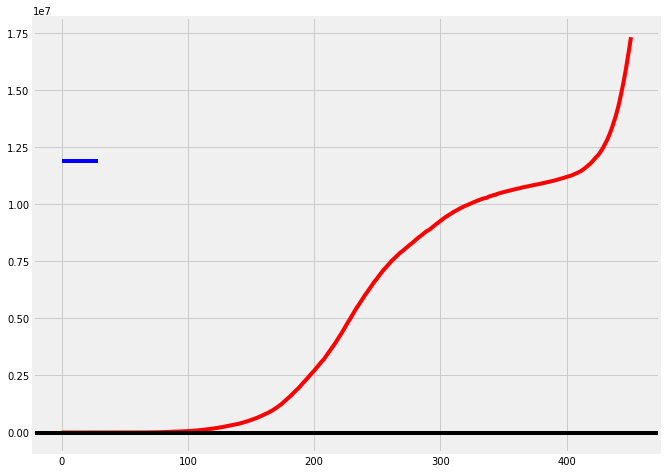

mse:  0.2587999408517316
rmsle:  0.18958078022237468
mae:  0.39523556076140387
mape:  0.20565542008464813
rmse:  0.5087238355451134


In [35]:
baseling_ARMA(india_df, 'confirmed')

In [36]:
india_df

,country,date,confirmed,fatalities,population_density,median_age,aged_65_older,aged_70_older,population,yearly_change,net_change,density,land_area,migrants,rert_rate,med_age,urban_pop,world_share,r_population
0,India,2020-01-30,1.0,0.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
1,India,2020-01-31,1.0,0.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
2,India,2020-02-01,1.0,0.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
3,India,2020-02-02,2.0,0.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
4,India,2020-02-03,3.0,0.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,India,2021-04-21,15930774.0,184659.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
448,India,2021-04-22,16263695.0,186922.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
449,India,2021-04-23,16610481.0,189546.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
450,India,2021-04-24,16960172.0,192313.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09


# ARAM

In [12]:
global_df['confirmed'].iloc[:-30].shape

(430,)

In [13]:
model = ARMA(global_df['confirmed'].iloc[:-30], order=(1,0)) #(1, 0)  (0, 1)  (0, 2) (0, 3) (3, 3)
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:              confirmed   No. Observations:                  430
Model:                     ARMA(1, 0)   Log Likelihood               -6123.991
Method:                       css-mle   S.D. of innovations         366146.168
Date:                Mon, 10 May 2021   AIC                          12253.982
Time:                        21:16:08   BIC                          12266.173
Sample:                             0   HQIC                         12258.796
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.869e+07   7.79e+07      0.497      0.619   -1.14e+08    1.91e+08
ar.L1.confirmed     1.0000   2.51e-05   3.99e+04      0.000       1.000       1.000
                                

In [14]:
np.array(result.predict(start=404,end=433)).shape

(30,)

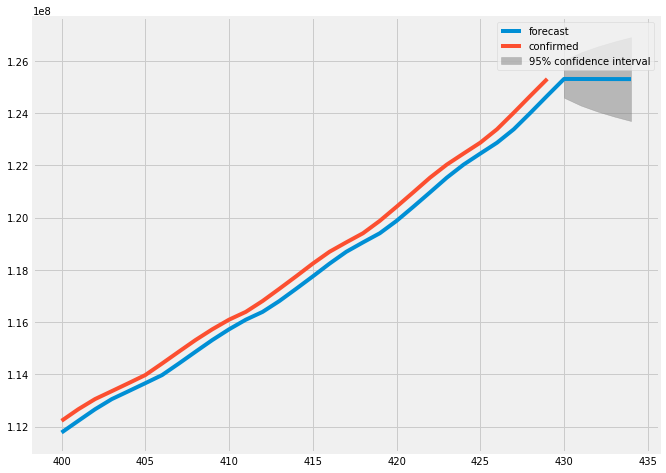

In [15]:
# Predicting simulated AR(1) model 
rcParams['figure.figsize'] = 10, 8
result.plot_predict(400, 434)
plt.show()

In [16]:
rmse = math.sqrt(mean_squared_error(global_df['confirmed'].iloc[400:434], result.predict(start=400,end=433)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 653606.822409206.


In [17]:
The root mean squared error is 128161.37744454228.

SyntaxError: invalid syntax (<ipython-input-17-806cadfbe26d>, line 1)

# MA

                             ARIMA Model Results                              
Dep. Variable:            D.confirmed   No. Observations:                  398
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4832.027
Method:                       css-mle   S.D. of innovations          45331.079
Date:                Thu, 01 Apr 2021   AIC                           9672.054
Time:                        16:06:38   BIC                           9688.000
Sample:                             1   HQIC                          9678.370
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1117.2211   2129.493      0.525      0.600   -3056.508    5290.950
ar.L1.D.confirmed     0.1034      0.049      2.093      0.036       0.007       0.200
ar.L2.D.confirmed    -0.

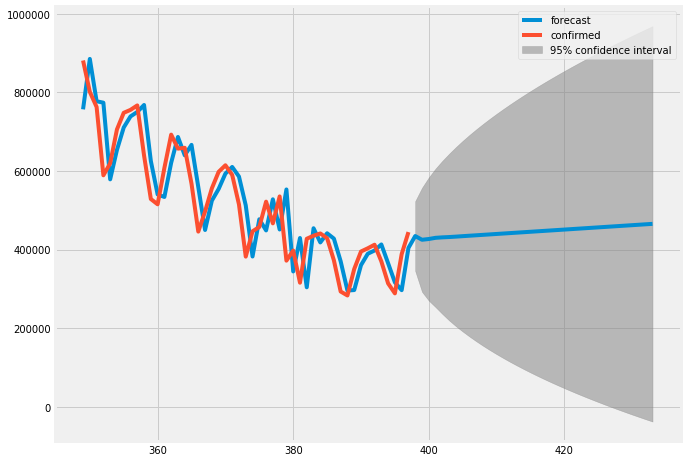

In [140]:
# Predicting the microsoft stocks volume
rcParams['figure.figsize'] = 10, 8
model = ARIMA(global_df['confirmed'].iloc[1:-34], order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(350, 434)
plt.show()

In [141]:
global_df['confirmed'].iloc[400:434].shape

(34,)

In [142]:
result.predict(start=399,end=433).shape

(35,)

In [143]:
rmse = math.sqrt(mean_squared_error(global_df['confirmed'].iloc[400:434], result.predict(start=399,end=433)[1:]))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 467955.591972731.


In [144]:
global_df.head()

,country,date,confirmed,fatalities,population,yearly_change,net_change,density,land_area,migrants,rert_rate,med_age,urban_pop,world_share
0,global,2020-01-22,0.0,0.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
1,global,2020-01-23,98.0,1.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
2,global,2020-01-24,286.0,8.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
3,global,2020-01-25,492.0,16.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
4,global,2020-01-26,685.0,14.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034


                                Statespace Model Results                               
Dep. Variable:     ['confirmed', 'fatalities']   No. Observations:                  400
Model:                              VARMA(2,1)   Log Likelihood               -8188.306
                                   + intercept   AIC                          16410.612
Date:                         Thu, 01 Apr 2021   BIC                          16478.466
Time:                                 16:25:56   HQIC                         16437.483
Sample:                                      0                                         
                                         - 400                                         
Covariance Type:                           opg                                         
Ljung-Box (L1) (Q):             4.61, 1.69   Jarque-Bera (JB):       146.61, 277.47
Prob(Q):                        0.03, 0.19   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):        23.09, 2.

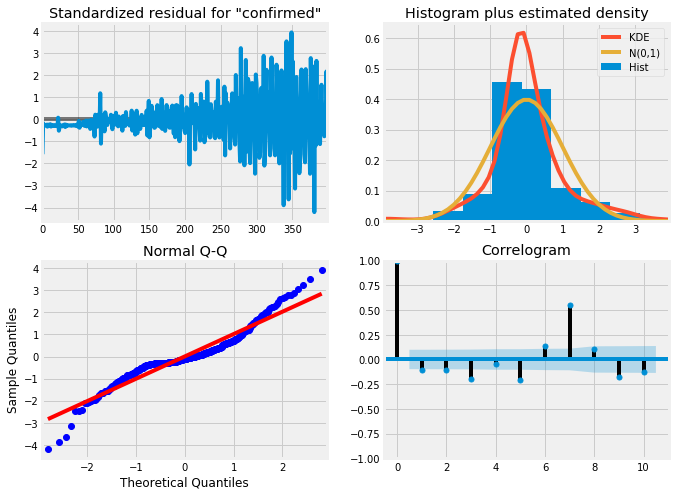

In [156]:
train_sample = pd.concat([global_df['confirmed'],global_df['fatalities']],axis=1)
model = sm.tsa.VARMAX(train_sample.iloc[:-34],order=(2,1),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
result.plot_diagnostics()

# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[400:434].values, result.predict(start=400, end=433)))
print("The root mean squared error is {}.".format(rmse))

## Logistic Regression

In [37]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

def dealDataConfirmed(country_df):
    df = pd.DataFrame()
    df['confirmed'] = country_df.iloc[:].confirmed.fillna(0)
    df['day_count'] = list(range(1,len(df)+1))

    ydata = [i for i in df.confirmed]
    xdata = df.day_count
    ydata = np.array(ydata, dtype=float).reshape([-1, 1])
    xdata = np.array(xdata, dtype=float).reshape([-1, 1])

    tamp = -30
    x_train = xdata[:tamp]
    x_test = xdata[tamp:]
    y_train = ydata[:tamp]
    y_test = ydata[tamp:]
    
    return xdata, ydata, x_train, y_train, x_test, y_test

def dealDataFatalities(country_df):
    df = pd.DataFrame()
    df['fatalities'] = country_df.iloc[:].fatalities.fillna(0)
    df['day_count'] = list(range(1,len(df)+1))

    ydata = [i for i in df.fatalities]
    xdata = df.day_count
    ydata = np.array(ydata, dtype=float).reshape([-1, 1])
    xdata = np.array(xdata, dtype=float).reshape([-1, 1])

    tamp = -30
    x_train = xdata[:tamp]
    x_test = xdata[tamp:]
    y_train = ydata[:tamp]
    y_test = ydata[tamp:]
    
    return xdata, ydata, x_train, y_train, x_test, y_test


# 回归部分
def try_different_method(model, ModelName, dealDataMethod, data):
    standData = StandData()
    data = standData.standData_(data)
    xdata, ydata, x_train, y_train, x_test, y_test = dealDataMethod(data)
    model.fit(x_train, y_train)
    score = model.score(xdata, ydata)
    result = model.predict(xdata)
    plt.figure()
    plt.plot(np.arange(len(result)), ydata, "go-", label="Measured")
    plt.plot(np.arange(len(result)), result, "ro-", label="Predicted")
    plt.title(f"method:{ModelName}---score:{score}")
    plt.legend(loc="best")
    plt.show()
    

    mse   = error_mse(y_test, model.predict(x_test))
    rmsle = error_rmsle(y_test, model.predict(x_test))
    mae   = error_mae(y_test, model.predict(x_test))
    mape  = error_mape(y_test, model.predict(x_test))
    rmse  = error_rmse(y_test, model.predict(x_test))
    print("mse: ", mse)
    print("rmsle: ", rmsle)
    print("mae: ", mae)
    print("mape: ", mape)
    print("rmse: ", rmse)    

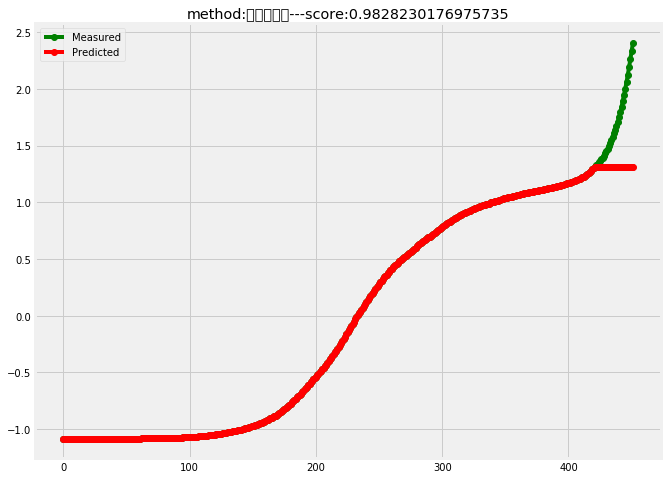

mse:  0.2587998658105169
rmsle:  0.18958074282019757
mae:  0.3952354947725932
mape:  0.20565538406202602
rmse:  0.5087237617907354


In [38]:
from sklearn import tree
model_decision_tree_regression = tree.DecisionTreeRegressor()
try_different_method(model_decision_tree_regression, "决策树回归", dealDataConfirmed, india_df)

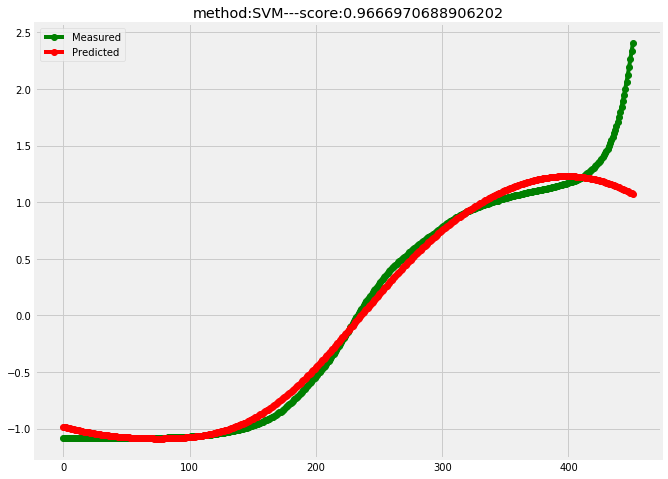

mse:  0.4515553456720639
rmsle:  0.2645037092113967
mae:  0.5688785568529128
mape:  0.3104987559723092
rmse:  0.6719786794773059


In [39]:
from sklearn import svm
model_svm = svm.SVR()
try_different_method(model_svm, "SVM", dealDataConfirmed, india_df)

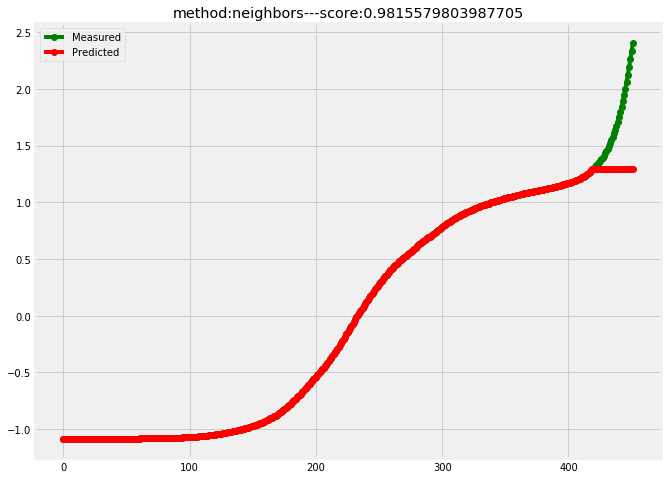

mse:  0.277833664885047
rmsle:  0.19775483847486566
mae:  0.4186226169268291
mape:  0.21977621743453124
rmse:  0.5270992931934618


In [40]:
from sklearn import neighbors
model_k_neighbor = neighbors.KNeighborsRegressor()
try_different_method(model_k_neighbor, "neighbors", dealDataConfirmed, india_df)

In [14]:
## 2019.11.1
#     time_step = 3       lstm-cell个数
#     n_inputs = 1        输入大小， 也就是look-back
#     n_outputs = 1       输出大小， 全连接输出
#     iter_epoch = 100    训练次数
#     batch_size = 10     每次训练的大小
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
config = tf.ConfigProto()

config.gpu_options.allow_growth = True

session = tf.Session(config=config)

def addCsv(df): #累加
    temp_df = df.copy()
    confirmed_ = np.array(temp_df['confirmed'].astype(np.float32)).reshape(-1, 1)
    fatalities_ = np.array(temp_df['fatalities'].astype(np.float32)).reshape(-1, 1)
    for i in range(confirmed_.shape[0] - 1):
        confirmed_[i+1] += confirmed_[i]
    for i in range(fatalities_.shape[0] - 1):
        fatalities_[i+1] += fatalities_[i]    
    temp_df['confirmed'] = confirmed_
    temp_df['fatalities'] = fatalities_
    return temp_df


## 将数据转换为x, y
## 这个函数将创造一个数据， x为时间t时刻的数据， y为时间t+1时刻的数据
## look_back  指代 我们需要过去多少个时间点的数据作为输入 预测下一个点的数据
def create_dataset_train(data, look_back=1, input_data = None):
    dataX1, dataY1 = create_dataset_front(data, look_back)
    dataX2, dataY2 = create_dataset_front(data, look_back)
    dataX = np.vstack([dataX1, dataX2])
    dataY = np.vstack([dataY1, dataY2])
    if input_data is not None:
        dataX3, dataY3 = create_train_sequences(input_data, look_back)
        dataX = np.vstack([dataX, dataX3])
        dataY = np.vstack([dataY, dataY3])
    return dataX, dataY

def create_train_sequences(input_data, look_back):
    dataX, dataY = [], []
    input_data = input_data.reshape(input_data.shape[0], input_data.shape[1])
    for i in range(input_data.shape[0]):
        dataX.append(input_data[i][0:look_back])
        dataY.append(input_data[i][look_back])
    return np.array(dataX), np.array(dataY).reshape([-1, 1])

def create_dataset_front(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data) - look_back):
        dataX.append(data[i:(i+look_back)])
        dataY.append(data[i+look_back])
    return np.array(dataX).reshape([-1, look_back]), np.array(dataY).reshape([-1, 1])

def create_dataset_back(data, look_back=1):
    dataX, dataY = [], []
    for i in range(look_back, len(data)):
        dataX.append(data[(i - look_back) : i])
        dataY.append(data[i])
    return np.array(dataX).reshape([-1, look_back]), np.array(dataY).reshape([-1, 1])

from sklearn.preprocessing import StandardScaler
class DealData:
    def __init__(self, path, extraDataPos = None):
        self.scaler = StandardScaler()
        self.amplitude = pd.read_csv('/home/soul/NewWorkSpace/Covid_2021_4_18/data/' + path + '.csv')
        self.amplitude = addCsv(self.amplitude)  ## 处理累加
        self.amplitude = np.array(self.amplitude['confirmed'].astype(np.float32))
        
        self.scaler.fit(self.amplitude.reshape(-1, 1))
        self.amplitude = self.scaler.transform(self.amplitude.reshape(-1, 1)).reshape(-1)
        
        if extraDataPos is not None:
            self.trainData = np.load(extraDataPos)
        else:
            self.trainData = None

        
    def trainTestData(self, look_back = 50):
        train_sampels = -30 
        test_samples = -80
        train_data = self.amplitude[:train_sampels]
        test_data = self.amplitude[test_samples:]
        
        trainX, trainY = create_dataset_train(train_data, look_back, self.trainData)
        testX, testY   = create_dataset_train(test_data, look_back)
        
        return trainX, trainY, testX, testY
    
    def transeformData(self, data):
        return self.scaler.inverse_transform(data)
    

def mean_square_error(pred, y):
    return np.power(np.sum(np.power(pred - y, 2)) / pred.shape[0], 0.5)


def lstm_net(X, y, batch_size, units=100, learning_rate=0.002):
    lstm_cells = []
    for i in range(2):
        lstm_cells.append(tf.contrib.rnn.BasicLSTMCell(units, forget_bias=1.0, state_is_tuple=True))

    multi_lstm = tf.contrib.rnn.MultiRNNCell(lstm_cells, state_is_tuple=True)

    init_state = multi_lstm.zero_state(batch_size, dtype=tf.float32)

    # batch_size, units
    outputs, final_state = tf.nn.dynamic_rnn(multi_lstm, X, initial_state=init_state, time_major=False)

    outputs = tf.reshape(outputs, [-1, units * X.shape[1]])
    result = tf.layers.dense(outputs, units=1, activation=None)

    loss = tf.reduce_mean(tf.square(y - result))
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)


    return result, loss, train_op


def train(path = "us", extraDataPos = None, lookback = 50):
    tf.reset_default_graph()
    
    dealData = DealData(path, extraDataPos)
    trainX, trainY, testX, testY = dealData.trainTestData(lookback)
    print(trainX.shape)
    print(trainY.shape)
    ## reshape input to [samples, time step, features]
    trainX = np.reshape(trainX, newshape=[trainX.shape[0], trainX.shape[1], 1])
    testX = np.reshape(testX, newshape=[testX.shape[0], testX.shape[1], 1])


    time_step = lookback
    n_inputs = 1
    n_outputs = 1
    iter_epoch = 100
    batch_size = 60


    x = tf.placeholder(tf.float32, shape=[None, time_step, n_inputs])
    y = tf.placeholder(tf.float32, shape=[None, n_outputs])
    result, loss, train_op = lstm_net(x, y, batch_size)


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        re_loss = []
        for i in range(iter_epoch):
            temp = 0
#             ls, _ = sess.run([loss, train_op], feed_dict = {x : trainX, y : trainY})
            for j in range(int(trainX.shape[0] / batch_size)):
                tx = trainX[(j * batch_size):((j + 1) * batch_size), :, :]
                ty = trainY[(j * batch_size):((j + 1) * batch_size), :]
                ls, _ = sess.run([loss, train_op], feed_dict={x: tx, y: ty})
                temp += ls
            print(i, temp / trainX.shape[0])
            re_loss.append(temp / trainX.shape[0])


        plt.plot(range(iter_epoch), re_loss, c='red')
        plt.show()


#         re_train = []
#         for j in range(int(trainX.shape[0] / batch_size)):
#             tx = trainX[(j * batch_size):((j + 1) * batch_size), :, :]
#             ty = trainY[(j * batch_size):((j + 1) * batch_size), :]
#             pred = sess.run([result], feed_dict={x: tx, y: ty})
#             re_train.append(pred)


        re_test = []
        re_test = sess.run([result], feed_dict={x: testX, y: testY})
#         for j in range(int(testX.shape[0])):
#             tx = testX[(j * batch_size):((j + 1) * batch_size), :, :]
#             ty = testY[(j * batch_size):((j + 1) * batch_size), :]
#             pred = sess.run([result], feed_dict={x: tx, y: ty})
#             re_test.append(pred)


#         re_train = np.array(re_train).reshape([-1, 1])
        re_test = np.array(re_test).reshape([-1, 1])


#         re_train = scaler.inverse_transform(re_train)
#         re_test = scaler.inverse_transform(re_test)
#         data = scaler.inverse_transform(data)


#         ## plot  训练集预测
#         plt.plot(range(re_train.shape[0]), re_train, label='Train Predict')
#         ## plot 测试集预测
#         plt.plot(range(tst, tst + re_test.shape[0]), re_test, label='Test Predict')
#         ## plot 实际数据
#         plt.plot(range(data.shape[0]), data, label='Data')
#         plt.legend()
#         plt.show()


#         print('Train Accuary  {:.3f}'.format(np.sqrt(mean_square_error(re_train, trainY[0:re_train.shape[0]]))))
        
        mse   = error_mse(testY, re_test)
        rmsle = error_rmsle(testY, re_test)
        mae   = error_mae(testY, re_test)
        mape  = error_mape(testY, re_test)
        rmse  = error_rmse(testY, re_test)
        print("mse: ", mse)
        print("rmsle: ", rmsle)
        print("mae: ", mae)
        print("mape: ", mape)
        print("rmse: ", rmse)



In [2]:
dealData = DealData("us")
trainX, trainY, testX, testY = dealData.trainTestData()
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(684, 50) (684, 1)
(60, 50) (60, 1)


In [20]:
data = pd.read_csv('/home/soul/NewWorkSpace/Covid_2021_4_18/data/India.csv')

In [21]:
data

,Unnamed: 0,country,date,confirmed,fatalities,population_density,median_age,aged_65_older,aged_70_older,population,yearly_change,net_change,density,land_area,migrants,rert_rate,med_age,urban_pop,world_share,r_population
0,41,India,2020-03-11,6.0,1.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
1,42,India,2020-03-12,11.0,0.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
2,43,India,2020-03-13,9.0,1.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
3,44,India,2020-03-14,20.0,0.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
4,45,India,2020-03-15,11.0,0.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,447,India,2021-04-21,314644.0,2104.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
407,448,India,2021-04-22,332921.0,2263.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
408,449,India,2021-04-23,346786.0,2624.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09
409,450,India,2021-04-24,349691.0,2767.0,450.419,28.2,5.989,3.414,0.957604,0.257812,1.0,0.017618,0.181548,-0.557901,0.314286,0.583333,0.35,0.958311,1.377234e+09


In [22]:
countryName = "India"
firstName = "india"

(1662, 50)
(1662, 1)
0 0.0024940552999389892
1 0.0042882380935909264
2 0.00256763054353547
3 0.0011341896190540024
4 0.0009284441341969905
5 0.00041566073656118996
6 0.0005045819253729103
7 0.0004911546409914604
8 0.00043054965980884435
9 0.00039815227304967443
10 0.0004148358950477147
11 0.00042802297931739434
12 0.00035949203483569834
13 0.0003359250741967064
14 0.0003133730090247909
15 0.00030943959551862254
16 0.00028432554627850506
17 0.00025602495390949847
18 0.0002252713758352736
19 0.00019341391857565526
20 0.00016309858415926954
21 0.0001369014566721648
22 0.00012332074257021794
23 0.00012259243826536522
24 0.00011308695366589305
25 9.343599090248988e-05
26 7.700989033077607e-05
27 6.199407386136825e-05
28 4.84769259310926e-05
29 4.032657383281287e-05
30 4.4347343028948346e-05
31 7.07919443352316e-05
32 0.00012419963468182226
33 0.00015979553607681086
34 0.00014443516645947006
35 0.00012716108768274524
36 0.00011376985739613967
37 0.00012829779220644664
38 0.000383319040826520

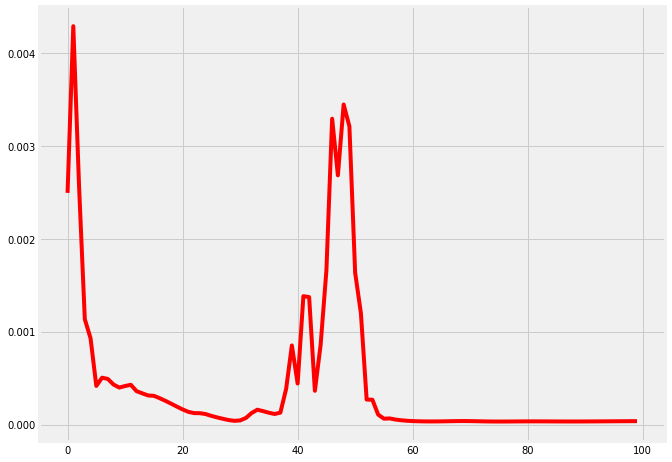

mse:  0.042172138
rmsle:  0.07333374
mae:  0.17369427
mape:  0.09814871
rmse:  0.20535856


In [41]:
# 使用Gan数据
if __name__ == '__main__':
    train(countryName, 
          "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_" +  firstName + "_del30_confirmed_noise_1000.npy", 50)

(1662, 50)
(1662, 1)
0 0.0023683655521147084
1 0.004223602833439261
2 0.0010195822644391503
3 0.0011960608363835192
4 0.0005401155124636979
5 0.0005615862156740792
6 0.0005452099122290828
7 0.0005128672978281526
8 0.000494478557317122
9 0.0004618731313345844
10 0.0004293890634919242
11 0.00042244994457560077
12 0.000599718824696921
13 0.0007445427159600579
14 0.0005446760670061164
15 0.0008985042235383677
16 0.0002900368213781327
17 0.002561571032804057
18 0.0006798827782993078
19 0.0006707233878185414
20 0.0001809211865585257
21 0.0011262643624071333
22 0.0003824985841807218
23 0.00020556828630785543
24 0.00011997013779343558
25 0.0001243932194405131
26 9.625034836369144e-05
27 8.137881376603495e-05
28 6.847235801569203e-05
47 2.3513210631597945e-05
48 3.239324405129829e-05
49 6.228731945157051e-05
50 0.00010388007779912766
51 0.00011778074610450503
52 0.00012586817966576437
53 0.0001428065444535767
54 0.00014842753138964875
55 0.0001464149114484176
56 0.00014028798781396152
57 0.0001

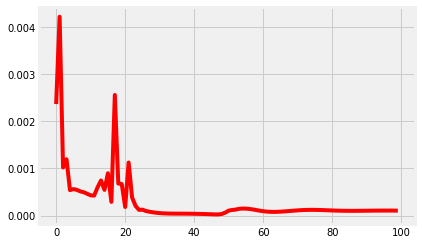

mse:  0.023114027
rmsle:  0.052018236
mae:  0.111604795
mape:  0.06050178
rmse:  0.15203299


In [24]:
# 使用随机噪声的GAN数据
if __name__ == '__main__':
    train(countryName, 
        "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_" + firstName + "_del30_confirmed_SJ_noise_1000.npy", 50)


(662, 50)
(662, 1)
0 0.0057440569168491305
1 0.0018907097316687516
2 0.0018327947743968572
3 0.0004786151697650957
4 0.00030970296464097937
5 0.00014839452356418378
6 0.00012506225443634366
7 0.00011446362677101662
8 0.000341588528925311
9 0.00033601119417417234
10 9.965739709541787e-05
11 8.945475090463897e-05
12 4.273474890333558e-05
13 2.7228947245713543e-05
14 2.801328412844663e-05
15 3.7817360609601e-05
16 7.790124574109906e-05
17 0.00020238910697954862
18 0.000332594797116482
19 0.00017954991665638715
20 5.4151161814395485e-05
21 2.4771967378207217e-05
22 2.0669994972860075e-05
23 2.0820488890803916e-05
24 2.695060642140712e-05
25 5.453098073828223e-05
26 0.00015641189417013972
27 0.0003492812529080364
28 0.0003954454844260414
29 0.00020718810715578253
30 5.5775543751498946e-05
31 2.132786558416962e-05
32 1.643732272739539e-05
33 1.831091289935671e-05
34 3.056296598823218e-05
35 7.889294627828106e-05
36 0.00021033547343855043
37 0.00032672620947498077
38 0.00022955893998222814
39

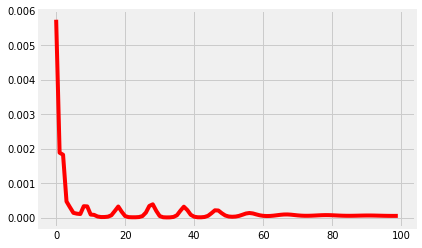

mse:  0.19597535
rmsle:  0.16716921
mae:  0.3601562
mape:  0.20005538
rmse:  0.44269103


In [25]:
# 不使用Gan数据
if __name__ == '__main__':
    train(countryName)